In [1]:
# Imports and settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
import joblib
import warnings
warnings.filterwarnings("ignore")

# matplotlib inline if in notebook
try:
    get_ipython()
    %matplotlib inline
except Exception:
    pass

In [2]:
# Paths
TRAIN_CSV = "train.csv"
TEST_CSV  = "test.csv"

assert os.path.exists(TRAIN_CSV), f"train file not found: {TRAIN_CSV}"
assert os.path.exists(TEST_CSV), f"test file not found: {TEST_CSV}"

In [3]:
# Load data
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)
print("Loaded: train", train.shape, "test", test.shape)

Loaded: train (104000, 35) test (25889, 34)


In [4]:
train.head()

id player_id  friend_count  social_interactions  guild_membership  \
0  PLY00001   P007453         140.0                 39.0               NaN   
1  PLY00002   P120776         126.0                 12.0               1.0   
2  PLY00003   P083055         157.0                 63.0               1.0   
3  PLY00004   P087827          89.0                 96.0               1.0   
4  PLY00005   P045133         159.0                 80.0               0.0   

   event_participation_rate  daily_login_streak  avg_session_length  \
0                 35.495321                86.0           94.186687   
1                 35.222611                27.0           76.694036   
2                 54.291374                 1.0           66.680997   
3                 52.990011                74.0           75.864572   
4                 78.586509                84.0           33.774836   

   sessions_per_week  total_playtime_hours  ...  purchase_frequency  \
0          20.660400            793.043827  ...                 NaN   
1          15.112974            836.397667  ...           11.193590   
2          13.770480            561.212807  ...            5.175272   
3          11.941930                   NaN  ...           10.374656   
4           1.405901            617.041867  ...                 NaN   

   payment_methods_used  purchases_on_discount  discount_rate_used  \
0                   1.0                    1.0            0.250000   
1                   1.0                   25.0            0.581395   
2                   3.0                   27.0            0.551020   
3                   2.0                   22.0            0.536585   
4                   3.0                   11.0            0.261905   

   seasonal_spending_pattern  owns_limited_edition  competitive_rank  \
0                        4.0                   NaN               7.0   
1                        5.0                   0.0               3.0   
2                        7.0                   0.0               5.0   
3                        6.0                   0.0               9.0   
4                        0.0                   1.0               4.0   

   tournament_participation  segment  spending_30d  
0                       1.0      1.0          0.00  
1                       0.0      1.0          0.00  
2                       0.0      1.0          0.00  
3                       0.0      2.0       2223.70  
4                       0.0      3.0     156634.22  

[5 rows x 35 columns]

In [5]:
test.head()

id player_id  friend_count  social_interactions  guild_membership  \
0  ANS00001   P128956         177.0                 71.0               0.0   
1  ANS00002   P115227          55.0                 99.0               0.0   
2  ANS00003   P013087          28.0                 69.0               1.0   
3  ANS00004   P045326          79.0                 78.0               1.0   
4  ANS00005   P052078         121.0                 84.0               0.0   

   event_participation_rate  daily_login_streak  avg_session_length  \
0                 33.157419               138.0          143.414888   
1                 27.683671                54.0          253.827162   
2                 75.184955               101.0          114.896217   
3                 17.440872                15.0          119.473134   
4                 52.693562                 4.0          176.099045   

   sessions_per_week  total_playtime_hours  ...  days_since_last_purchase  \
0           7.151850           1051.879412  ...                 47.642882   
1          31.460513            433.186064  ...                       NaN   
2          34.737910            669.426704  ...                  1.093810   
3                NaN            729.958232  ...                 11.347458   
4          12.882396            520.605664  ...                 51.459694   

   purchase_frequency  payment_methods_used  purchases_on_discount  \
0            3.579685                   3.0                    6.0   
1            5.155740                   NaN                    5.0   
2           13.880698                   4.0                   20.0   
3           18.308044                   3.0                   23.0   
4            2.587987                   2.0                   17.0   

   discount_rate_used  seasonal_spending_pattern  owns_limited_edition  \
0            0.375000                        1.0                   0.0   
1            0.263158                        9.0                   0.0   
2            0.512821                        6.0                   0.0   
3            0.589744                        2.0                   0.0   
4            0.531250                        0.0                   0.0   

   competitive_rank  tournament_participation  segment  
0              10.0                       0.0      1.0  
1               5.0                       0.0      1.0  
2               5.0                       0.0      3.0  
3               5.0                       0.0      0.0  
4               6.0                       0.0      2.0  

[5 rows x 34 columns]

count    104000.000000
mean      10369.578412
std       30261.013990
min           0.000000
25%           0.000000
50%          74.725000
75%        2436.285000
max      300000.000000
Name: spending_30d, dtype: float64
Zero spending rate: 0.482


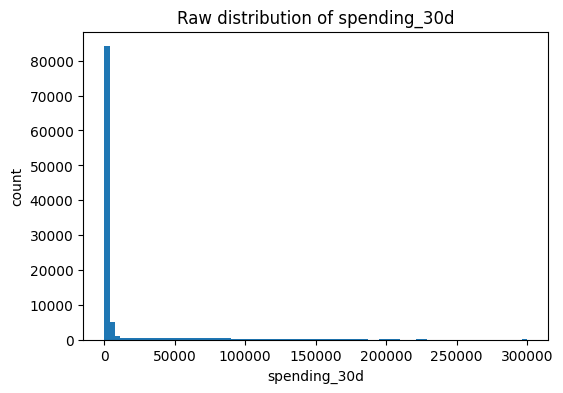

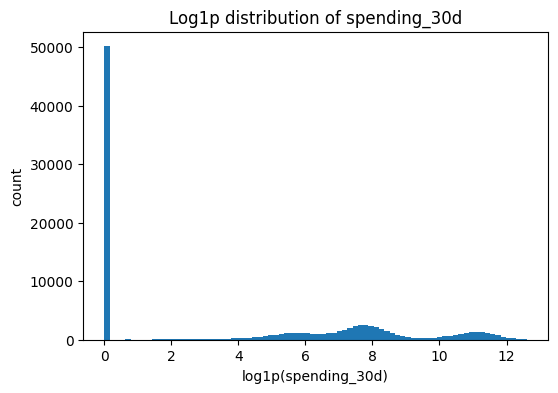

In [6]:
# Basic checks and target diagnostics
TARGET = "spending_30d"
if TARGET not in train.columns:
    raise ValueError(f"Target column {TARGET} not found in train.csv")

print(train[TARGET].describe())
zero_rate = (train[TARGET] == 0).mean()
print(f"Zero spending rate: {zero_rate:.3f}")

# Visualize distribution of target (log scale for readability)
plt.figure(figsize=(6,4))
plt.hist(train[TARGET].values, bins=80)
plt.title('Raw distribution of spending_30d')
plt.xlabel('spending_30d')
plt.ylabel('count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log1p(train[TARGET].values), bins=80)
plt.title('Log1p distribution of spending_30d')
plt.xlabel('log1p(spending_30d)')
plt.ylabel('count')
plt.show()

Numeric features: 32

Top 10 skewed numeric features:
 avg_transaction_value       32.693155
prev_month_spending          3.246635
historical_spending          3.199734
tournament_participation     2.897423
owns_limited_edition         2.564573
is_premium_member            1.999533
cross_game_activity          1.551818
vip_status                   1.162282
payment_methods_used         0.994133
purchases_on_discount        0.968385
dtype: float64

Missing values (top 20):
primary_game                   6168
sessions_per_week              6162
days_since_last_purchase       6148
total_transactions             6133
total_playtime_hours           6132
payment_methods_used           6108
daily_login_streak             6107
social_interactions            6106
account_age_days               6102
historical_spending            6099
platform                       6095
vip_status                     6094
cross_game_activity            6083
owns_limited_edition           6075
segment             

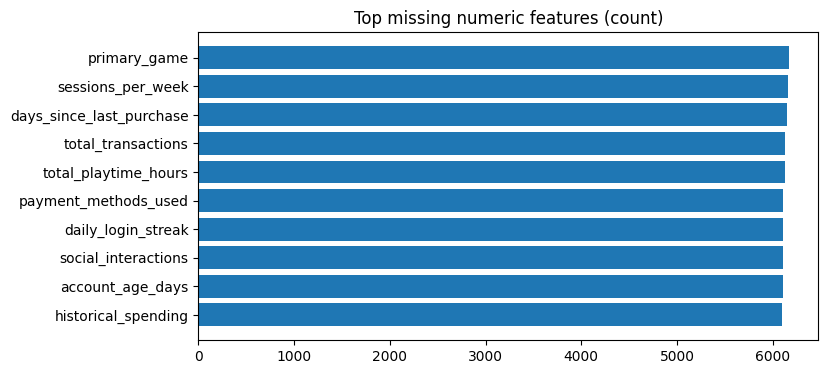

In [7]:
# Identify numeric features and missing/skew
exclude = [TARGET, 'id', 'Id', 'ID', 'index']
all_features = [c for c in train.columns if c not in exclude]
numeric_features = [c for c in all_features if np.issubdtype(train[c].dtype, np.number)]
print('Numeric features:', len(numeric_features))

skewness = train[numeric_features].skew().abs().sort_values(ascending=False)
print('\nTop 10 skewed numeric features:\n', skewness.head(10))

# Missing values (top 20)
ms = train.isna().sum().sort_values(ascending=False).head(20)
print('\nMissing values (top 20):')
print(ms)

# Visualize missingness for top numeric features
top_missing = ms[ms > 0].index.tolist()[:10]
if top_missing:
    plt.figure(figsize=(8,4))
    plt.barh(top_missing[::-1], train[top_missing].isna().sum()[top_missing][::-1])
    plt.title('Top missing numeric features (count)')
    plt.show()

In [8]:
# Two-stage target creation
train['will_spend'] = (train[TARGET] > 0).astype(int)
train['log_spend'] = np.log1p(train[TARGET])

# Show group sizes
print(train['will_spend'].value_counts(normalize=True))

will_spend
1    0.517962
0    0.482038
Name: proportion, dtype: float64


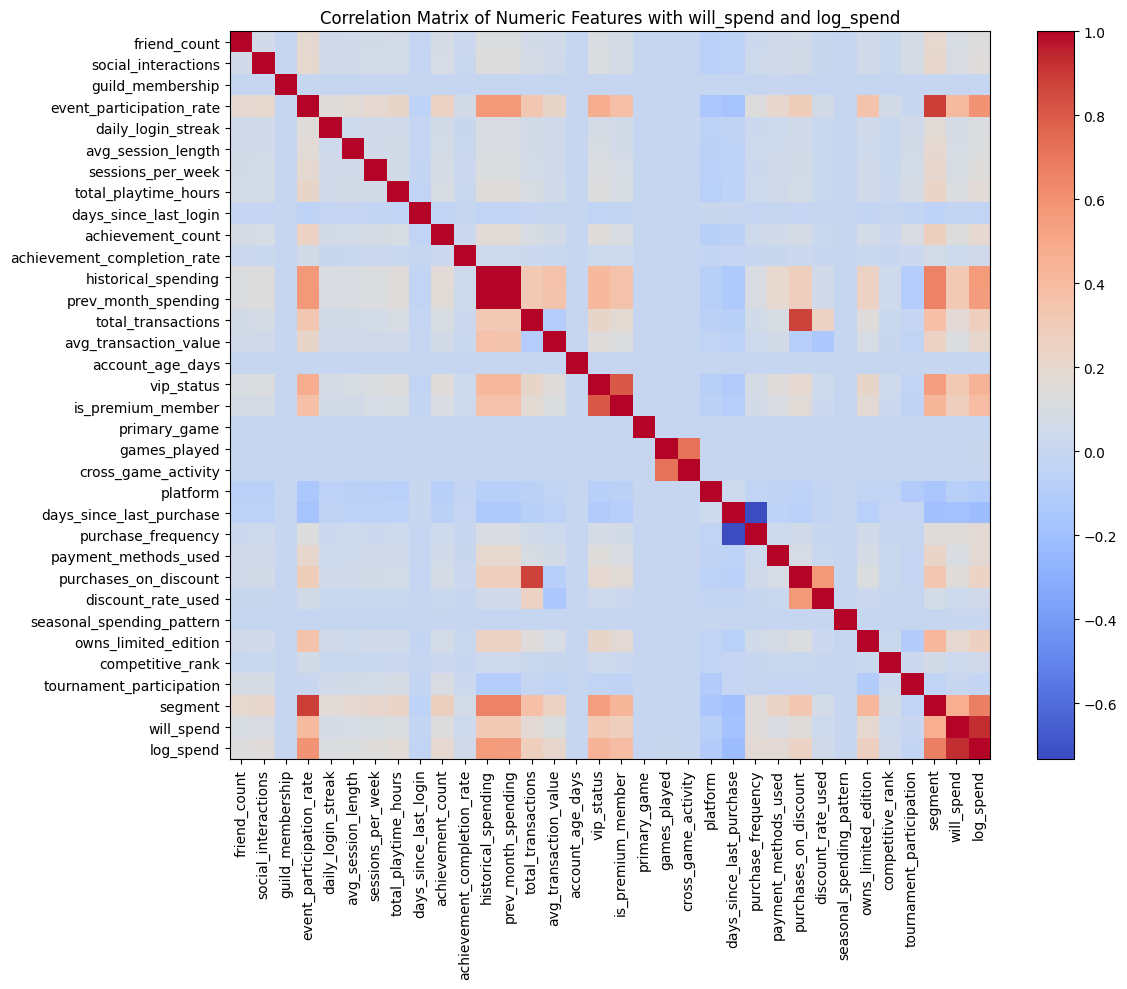

In [9]:
# Visualize correlation heatmap including will_spend and log_spend targets

# Combine numeric features with the two-stage target columns
all_cols_for_corr = numeric_features + ['will_spend', 'log_spend']

# Ensure all selected columns exist in the DataFrame and filter out any that might have been dropped
existing_cols = [col for col in all_cols_for_corr if col in train.columns]

# Calculate the correlation matrix
cor_matrix = train[existing_cols].corr()

plt.figure(figsize=(12, 10))
plt.imshow(cor_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation Matrix of Numeric Features with will_spend and log_spend')
plt.xticks(range(len(existing_cols)), existing_cols, rotation=90)
plt.yticks(range(len(existing_cols)), existing_cols)
plt.tight_layout()
plt.show()

In [10]:
# Feature engineering helper
def add_engineered(df):
    df = df.copy()
    def safe_div(a, b):
        return a / (b.replace({0: np.nan}))
    if 'total_transactions' in df.columns and 'total_playtime_hours' in df.columns:
        df['tx_per_playhour'] = safe_div(df['total_transactions'], df['total_playtime_hours']).fillna(0)
    if 'prev_month_spending' in df.columns and 'account_age_days' in df.columns:
        df['spend_per_day_account'] = safe_div(df['prev_month_spending'], df['account_age_days']).fillna(0)
    if 'discount_rate_used' in df.columns and 'purchases_on_discount' in df.columns:
        df['heavy_discount_user'] = ((df['discount_rate_used'] > 0.5) & (df['purchases_on_discount'] > 5)).astype(int)
    return df

train_feat = add_engineered(train[numeric_features].fillna(0))
test_feat  = add_engineered(test[numeric_features].fillna(0))
print("Feature count after engineering:", train_feat.shape[1])

Feature count after engineering: 35


In [11]:
train_feat

friend_count  social_interactions  guild_membership  \
0              140.0                 39.0               0.0   
1              126.0                 12.0               1.0   
2              157.0                 63.0               1.0   
3               89.0                 96.0               1.0   
4              159.0                 80.0               0.0   
...              ...                  ...               ...   
103995          81.0                 54.0               1.0   
103996         117.0                 62.0               1.0   
103997         217.0                  4.0               1.0   
103998          89.0                  0.0               1.0   
103999          91.0                 34.0               1.0   

        event_participation_rate  daily_login_streak  avg_session_length  \
0                      35.495321                86.0           94.186687   
1                      35.222611                27.0           76.694036   
2                      54.291374                 1.0           66.680997   
3                      52.990011                74.0           75.864572   
4                      78.586509                84.0           33.774836   
...                          ...                 ...                 ...   
103995                 67.570582               105.0           36.785310   
103996                 32.805233                79.0          151.619561   
103997                 11.347544                73.0           61.428907   
103998                 17.576616                68.0           54.914447   
103999                 47.443878                32.0          135.136033   

        sessions_per_week  total_playtime_hours  days_since_last_login  \
0               20.660400            793.043827               6.918242   
1               15.112974            836.397667               3.514021   
2               13.770480            561.212807               1.863368   
3               11.941930              0.000000               5.973982   
4                1.405901            617.041867               5.570188   
...                   ...                   ...                    ...   
103995           6.671382            860.003706               7.762639   
103996           6.211211            173.501198              11.287810   
103997           7.193119            691.056362              19.752612   
103998           6.288369            362.560021               3.407455   
103999           2.758940            466.649713               9.645633   

        achievement_count  ...  purchases_on_discount  discount_rate_used  \
0                   375.0  ...                    1.0            0.250000   
1                   111.0  ...                   25.0            0.581395   
2                    82.0  ...                   27.0            0.551020   
3                   122.0  ...                   22.0            0.536585   
4                   189.0  ...                   11.0            0.261905   
...                   ...  ...                    ...                 ...   
103995              131.0  ...                    3.0            0.428571   
103996              249.0  ...                    6.0            0.260870   
103997              221.0  ...                    5.0            0.454545   
103998              261.0  ...                    4.0            0.266667   
103999              145.0  ...                   34.0            0.586207   

        seasonal_spending_pattern  owns_limited_edition  competitive_rank  \
0                             4.0                   0.0               7.0   
1                             5.0                   0.0               3.0   
2                             7.0                   0.0               5.0   
3                             6.0                   0.0               9.0   
4                             0.0                   1.0               4.0   
...                           ...                   ...       

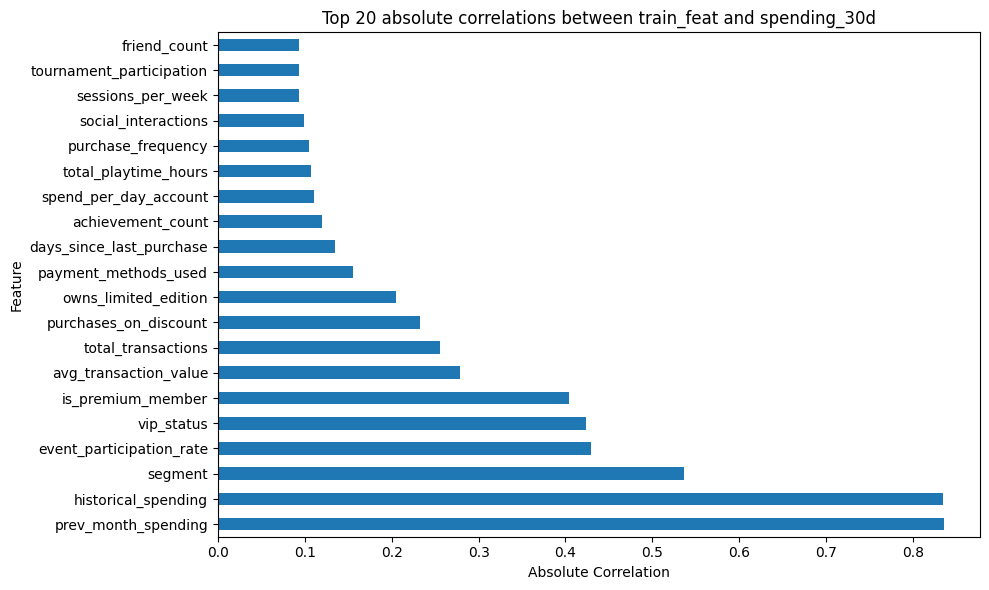

In [12]:
# Correlation heatmap for train_feat with target
# Make sure the target column is aligned with train_feat indices
if 'spending_30d' in train.columns:
    target_series = train['spending_30d']
    # Align indices to ensure correct correlation calculation
    train_feat_aligned = train_feat.loc[target_series.index]

    correlations = train_feat_aligned.corrwith(target_series).abs().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    correlations.head(20).plot(kind='barh') # Plot top 20 correlations
    plt.title('Top 20 absolute correlations between train_feat and spending_30d')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Target column 'spending_30d' not found in train DataFrame.")

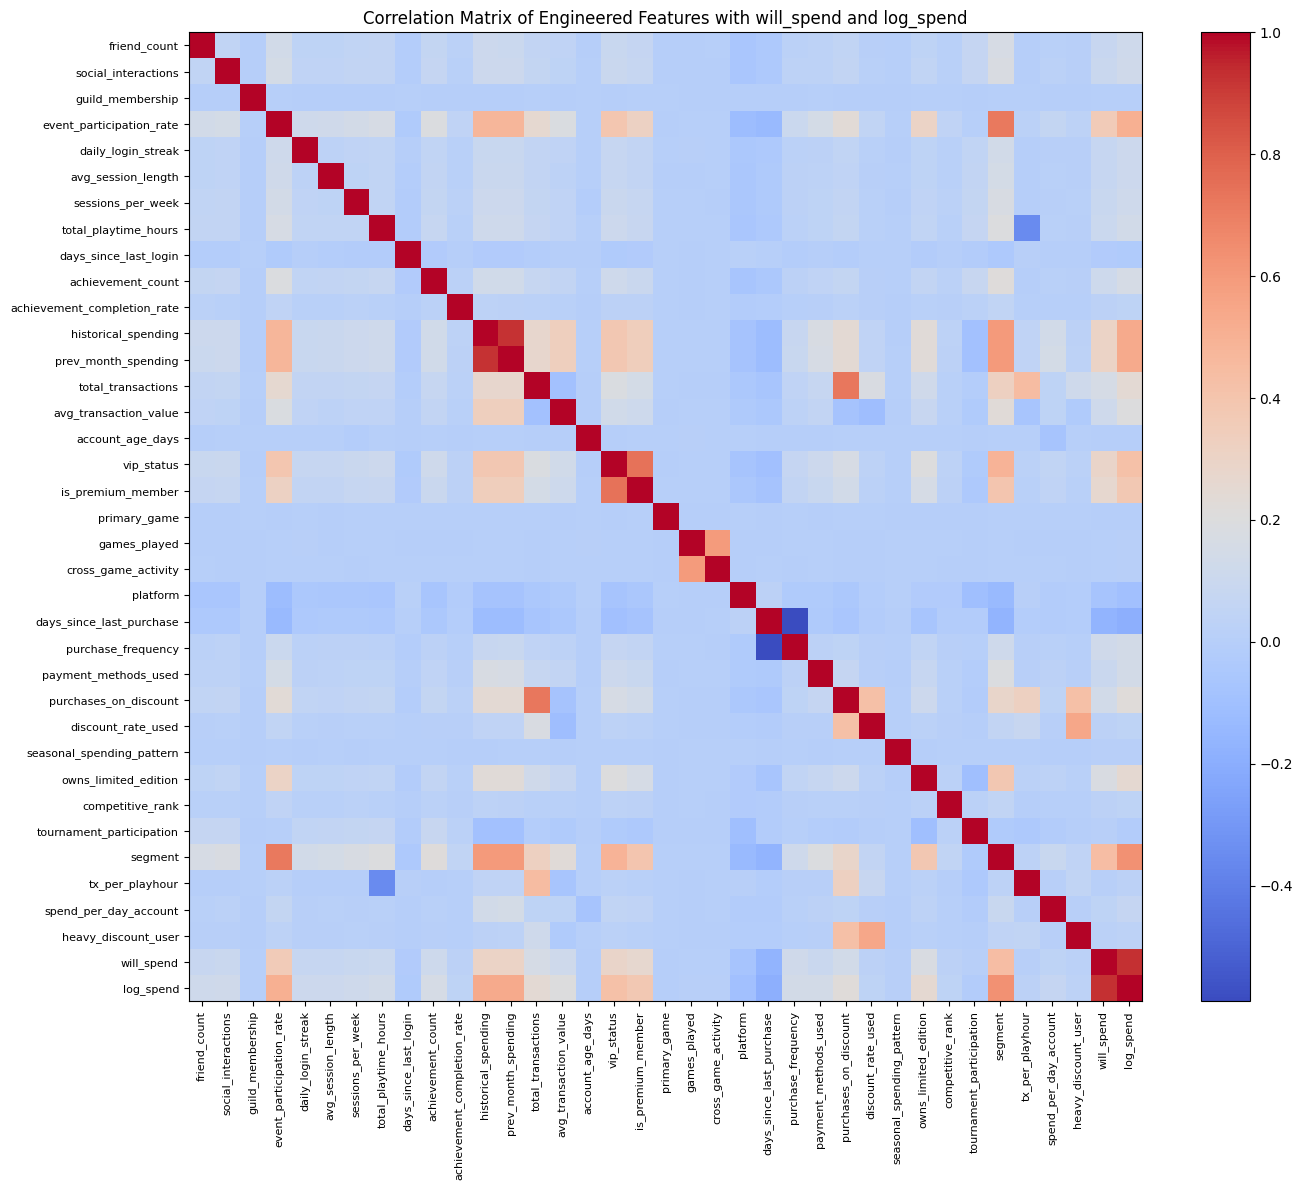

In [13]:
# Visualize correlation heatmap for train_feat with will_spend and log_spend

# Ensure `train_feat` and `train` DataFrames are aligned by index
# Create a combined DataFrame for correlation calculation
combined_for_corr = train_feat.copy()
combined_for_corr['will_spend'] = train['will_spend']
combined_for_corr['log_spend'] = train['log_spend']

# Calculate the correlation matrix
cor_matrix_engineered_targets = combined_for_corr.corr()

plt.figure(figsize=(14, 12))
plt.imshow(cor_matrix_engineered_targets, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation Matrix of Engineered Features with will_spend and log_spend')

# Set x and y ticks to feature names
feature_names = combined_for_corr.columns.tolist()
plt.xticks(range(len(feature_names)), feature_names, rotation=90, fontsize=8)
plt.yticks(range(len(feature_names)), feature_names, fontsize=8)
plt.tight_layout()
plt.show()

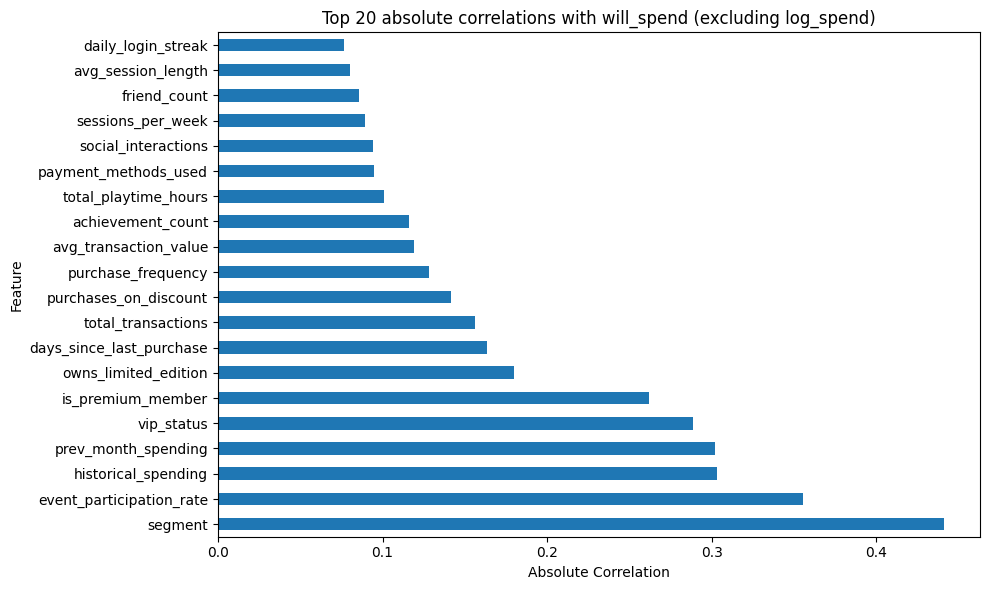

In [14]:
# Get correlations for 'will_spend' from the engineered features
will_spend_correlations = cor_matrix_engineered_targets['will_spend'].abs().sort_values(ascending=False)

# Exclude 'will_spend' and 'log_spend' from the list of features
will_spend_correlations = will_spend_correlations[~will_spend_correlations.index.isin(['will_spend', 'log_spend'])]

plt.figure(figsize=(10, 6))
will_spend_correlations.head(20).plot(kind='barh')
plt.title('Top 20 absolute correlations with will_spend (excluding log_spend)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

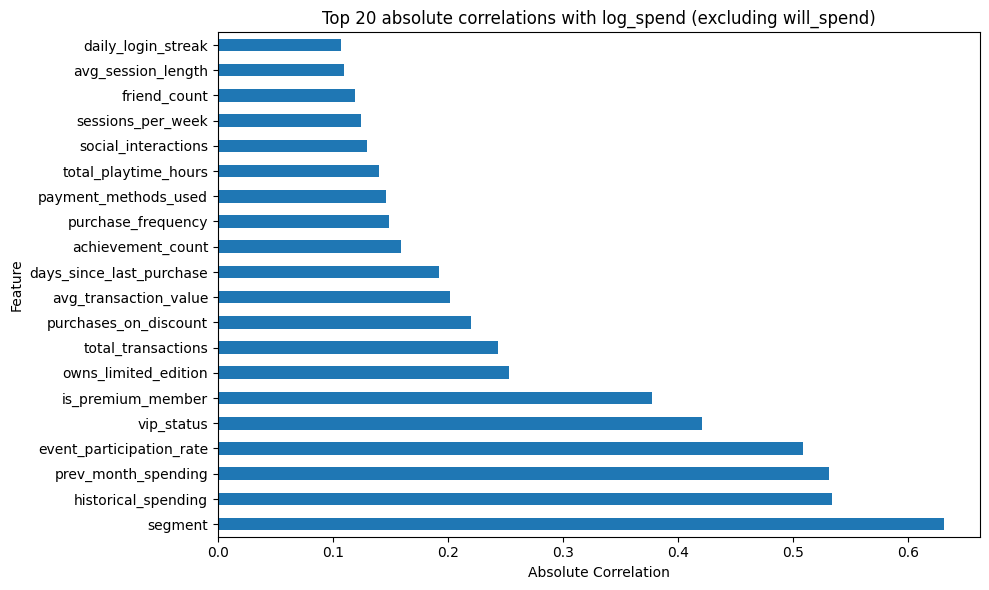

In [15]:
# Get correlations for 'log_spend' from the engineered features
log_spend_correlations = cor_matrix_engineered_targets['log_spend'].abs().sort_values(ascending=False)

# Exclude 'log_spend' and 'will_spend' from the list of features
log_spend_correlations = log_spend_correlations[~log_spend_correlations.index.isin(['log_spend', 'will_spend'])]

plt.figure(figsize=(10, 6))
log_spend_correlations.head(20).plot(kind='barh')
plt.title('Top 20 absolute correlations with log_spend (excluding will_spend)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [16]:
# PCA on selected columns
pca_columns = numeric_features[:40] if len(numeric_features) > 0 else []
if len(pca_columns) > 0:
    scaler = StandardScaler()
    scaler.fit(pd.concat([train_feat[pca_columns], test_feat[pca_columns]], axis=0))
    X_all_scaled = scaler.transform(pd.concat([train_feat[pca_columns], test_feat[pca_columns]], axis=0))
    pca = PCA(n_components=min(6, X_all_scaled.shape[1]), random_state=42)
    pca_res = pca.fit_transform(X_all_scaled)
    train_pca = pca_res[:len(train_feat)]
    test_pca  = pca_res[len(train_feat):]
    for i in range(train_pca.shape[1]):
        train_feat[f'PC{i+1}'] = train_pca[:, i]
        test_feat[f'PC{i+1}']  = test_pca[:, i]
    print('PCA explained variance (first components):', np.round(pca.explained_variance_ratio_[:5], 4))

PCA explained variance (first components): [0.1396 0.0556 0.0498 0.0481 0.0429]


In [17]:
# Anomaly detection
if len(pca_columns) > 0:
    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    iso.fit(train_feat[pca_columns].fillna(0))
    train_feat['anomaly'] = (iso.predict(train_feat[pca_columns].fillna(0)) == -1).astype(int)
    test_feat['anomaly'] = (iso.predict(test_feat[pca_columns].fillna(0)) == -1).astype(int)
    print('Anomalies flagged in train:', train_feat['anomaly'].sum())
    print('Anomalies flagged in test:', test_feat['anomaly'].sum())
else:
    train_feat['anomaly'] = 0
    test_feat['anomaly'] = 0

Anomalies flagged in train: 1040
Anomalies flagged in test: 301


In [18]:
# Prepare final feature set and split
FEATURES = train_feat.columns.tolist()
X = train_feat[FEATURES].fillna(0)
y_clf = train['will_spend']
y_reg = train['log_spend']
y_cont = train[TARGET]

X_train, X_val, y_clf_train, y_clf_val, y_reg_train, y_reg_val, y_cont_train, y_cont_val = train_test_split(
    X, y_clf, y_reg, y_cont, test_size=0.2, stratify=y_clf, random_state=42
)
print('Shapes: X_train', X_train.shape, 'X_val', X_val.shape)

Shapes: X_train (83200, 42) X_val (20800, 42)


In [19]:
# Models helpers
def get_classifier():
    try:
        import lightgbm as lgb
        return lgb.LGBMClassifier(n_estimators=800, random_state=42)
    except Exception:
        return HistGradientBoostingClassifier(random_state=42, max_iter=300)

def get_regressor():
    try:
        import lightgbm as lgb
        return lgb.LGBMRegressor(n_estimators=1200, learning_rate=0.05, random_state=42)
    except Exception:
        return HistGradientBoostingRegressor(random_state=42, max_iter=400)

clf = get_classifier()
reg = get_regressor()
print('Classifier:', clf)
print('Regressor:', reg)

Classifier: LGBMClassifier(n_estimators=800, random_state=42)
Regressor: LGBMRegressor(learning_rate=0.05, n_estimators=1200, random_state=42)



Training classifier for will_spend ...
[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858


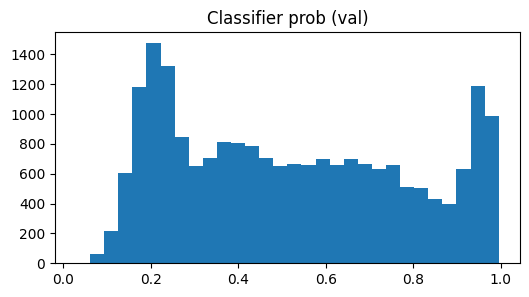

In [20]:
# Train classifier
print('\nTraining classifier for will_spend ...')
clf.fit(X_train, y_clf_train)
clf_val_prob = clf.predict_proba(X_val)[:, 1] if hasattr(clf, 'predict_proba') else clf.predict(X_val)

plt.figure(figsize=(6,3)); plt.hist(clf_val_prob, bins=30); plt.title('Classifier prob (val)'); plt.show()

In [21]:
# Train regressor (on positives if enough)
pos_mask = (y_clf_train == 1)
if pos_mask.sum() < 50:
    print('Too few positive examples; training regressor on all samples.')
    reg.fit(X_train, y_reg_train)
else:
    reg.fit(X_train[pos_mask], y_reg_train[pos_mask])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6633
[LightGBM] [Info] Number of data points in the train set: 43094, number of used features: 42
[LightGBM] [Info] Start training from score 7.950283


Validation MAE: 2720.6936. Normalized MAE: 0.2734


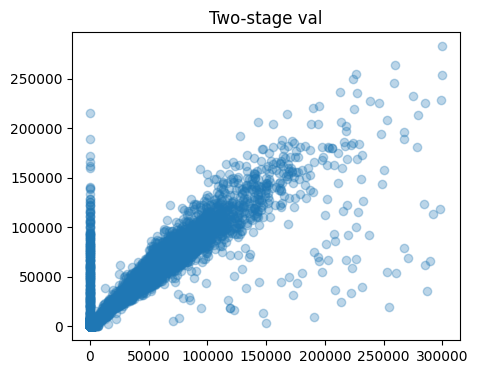

In [22]:
# Two-stage validation predictions
reg_val_log = np.zeros(len(X_val))
will_mask_val = clf_val_prob > 0.5
if will_mask_val.sum() > 0:
    try:
        reg_val_log[will_mask_val] = reg.predict(X_val[will_mask_val])
    except Exception:
        reg_val_log = reg.predict(X_val)
reg_val = np.expm1(reg_val_log).clip(min=0)

mae = mean_absolute_error(y_cont_val, reg_val)
normalized_mae = mae / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
print(f"Validation MAE: {mae:.4f}. Normalized MAE: {normalized_mae:.4f}")

plt.figure(figsize=(5,4)); plt.scatter(y_cont_val, reg_val, alpha=0.3); plt.title('Two-stage val'); plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 4.117902
Baseline Normalized MAE: 0.5943


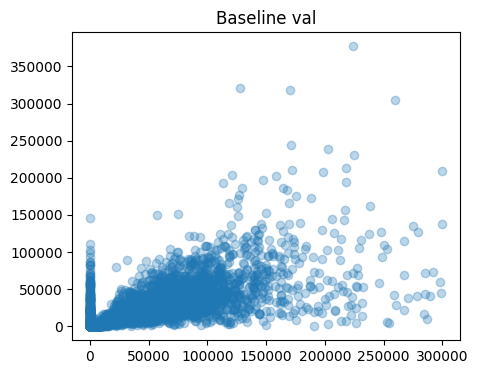

In [23]:
# Baseline: single regressor on all data
reg_all = clone(reg)
reg_all.fit(X_train, y_reg_train)
reg_all_pred = np.expm1(reg_all.predict(X_val))
mae_all = mean_absolute_error(y_cont_val, reg_all_pred)
normalized_mae_all = mae_all / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
print(f"Baseline Normalized MAE: {normalized_mae_all:.4f}")

plt.figure(figsize=(5,4)); plt.scatter(y_cont_val, reg_all_pred, alpha=0.3); plt.title('Baseline val'); plt.show()

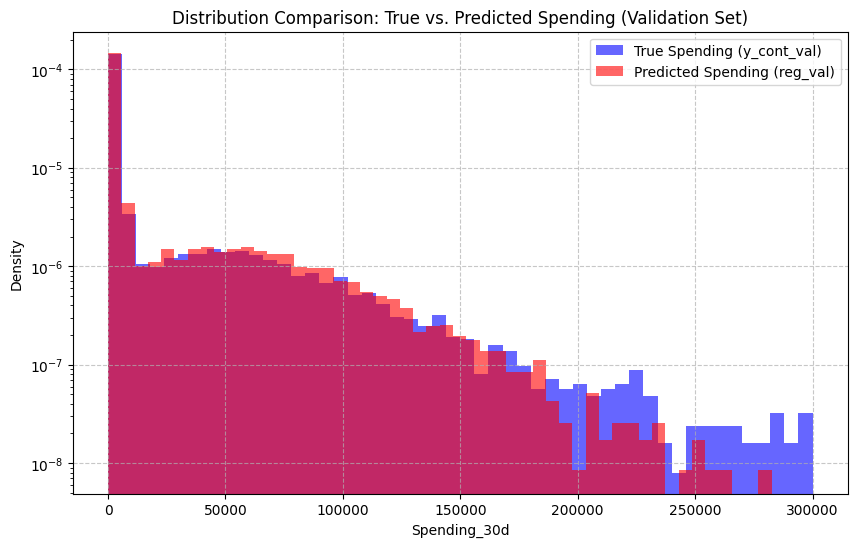

In [24]:
# Create a distribution plot comparing y_cont_val and reg_val
plt.figure(figsize=(10, 6))

# Plot histogram for true values
plt.hist(y_cont_val, bins=50, alpha=0.6, label='True Spending (y_cont_val)', color='blue', density=True)

# Plot histogram for predicted values
plt.hist(reg_val, bins=50, alpha=0.6, label='Predicted Spending (reg_val)', color='red', density=True)

plt.title('Distribution Comparison: True vs. Predicted Spending (Validation Set)')
plt.xlabel('Spending_30d')
plt.ylabel('Density')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [25]:
# Save basic two-stage models (optional)
joblib.dump(clf, 'model_classifier.joblib')
joblib.dump(reg, 'model_regressor_pos.joblib')
joblib.dump(reg_all, 'model_regressor_all.joblib')
print('Saved basic models to disk')

Saved basic models to disk


XGBRegressor: NMAE = 0.3181


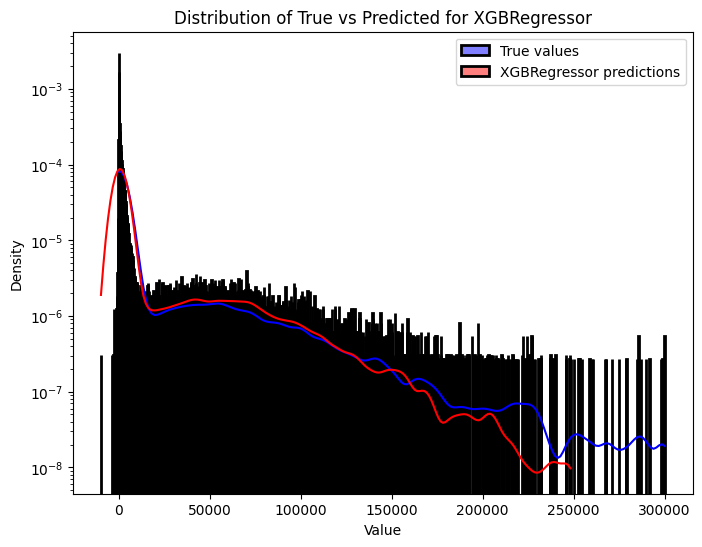

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
LightGBM: NMAE = 0.3132


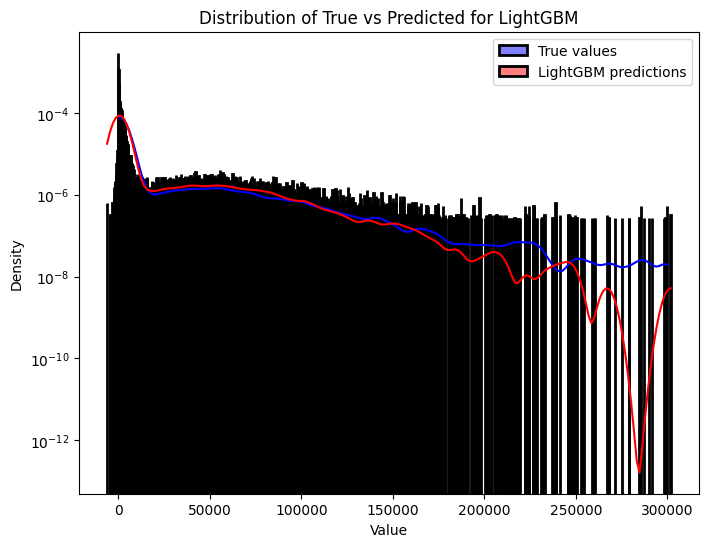

CatBoost not available or failed
NeuralNet: NMAE = 0.3318


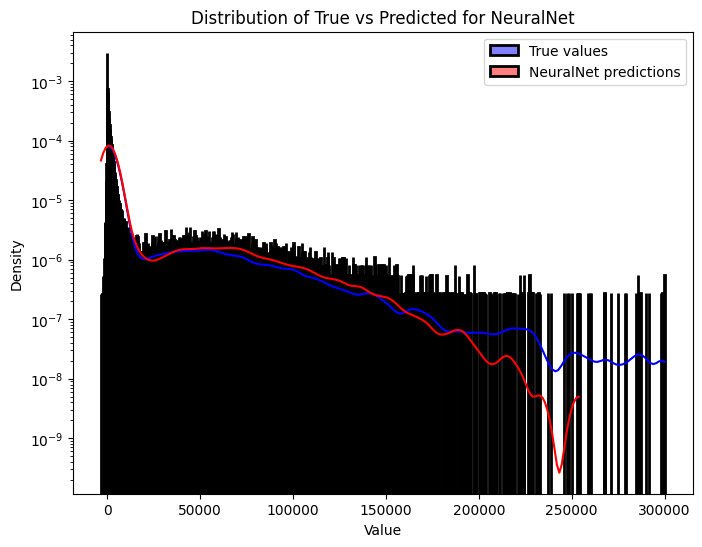

Sorted model performances:
  LightGBM: NMAE=0.3132
  XGBRegressor: NMAE=0.3181
  NeuralNet: NMAE=0.3318


In [26]:
# ---------------------------------------------------------------------
# Multi-model training (XGBoost / LightGBM / CatBoost / MLP)
# ---------------------------------------------------------------------
# We'll build models dict and results dict for NMAE on validation
models = {}
results = {}

Xtr, Xv = X_train, X_val
ytr, yv = y_cont_train, y_cont_val

def evaluate_model(name, model):
    # Fit model and make predictions
    model.fit(Xtr, ytr)
    pred = model.predict(Xv)

    # Calculate NMAE (Normalized Mean Absolute Error)
    mae_loc = mean_absolute_error(yv, pred)
    nmae_loc = mae_loc / (yv.mean() if yv.mean() > 0 else 1.0)
    results[name] = nmae_loc
    models[name] = model

    # Print results
    print(f"{name}: NMAE = {nmae_loc:.4f}")

    # Plot distribution comparison
    plt.figure(figsize=(8, 6))
    sns.histplot(yv, kde=True, color='blue', label='True values', stat='density', linewidth=2)
    sns.histplot(pred, kde=True, color='red', label=f'{name} predictions', stat='density', linewidth=2)
    plt.title(f"Distribution of True vs Predicted for {name}")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Try XGBoost
try:
    from xgboost import XGBRegressor
    evaluate_model("XGBRegressor", XGBRegressor(n_estimators=600, max_depth=8, learning_rate=0.05, random_state=42, verbosity=0))
except Exception:
    print("XGBoost not available or failed")

# Try LightGBM
try:
    from lightgbm import LGBMRegressor
    evaluate_model("LightGBM", LGBMRegressor(n_estimators=800, learning_rate=0.05, random_state=42))
except Exception:
    print("LightGBM not available or failed")

# Try CatBoost
try:
    from catboost import CatBoostRegressor
    evaluate_model("CatBoost", CatBoostRegressor(iterations=800, learning_rate=0.05, verbose=0, random_state=42))
except Exception:
    print("CatBoost not available or failed")

# MLP fallback
from sklearn.neural_network import MLPRegressor
evaluate_model("NeuralNet", MLPRegressor(hidden_layer_sizes=(128,64), max_iter=500, random_state=42))

# If no model succeeded (unlikely), include reg_all as baseline model
if len(models) == 0:
    models['RegAll'] = reg_all
    results['RegAll'] = normalized_mae_all

# Show sorted performances
print("Sorted model performances:")
for k, v in sorted(results.items(), key=lambda x: x[1]):
    print(f"  {k}: NMAE={v:.4f}")

Top models chosen for avg ensemble: ['LightGBM', 'XGBRegressor', 'NeuralNet']
Avg ensemble NMAE: 0.2965
Inverse-NMAE weights:
  XGBRegressor: 0.336
  LightGBM: 0.341
  NeuralNet: 0.322
Inverse-weighted ensemble NMAE: 0.2966
Softmax weights:
  XGBRegressor: 0.334
  LightGBM: 0.336
  NeuralNet: 0.330
Softmax-weighted ensemble NMAE: 0.2966


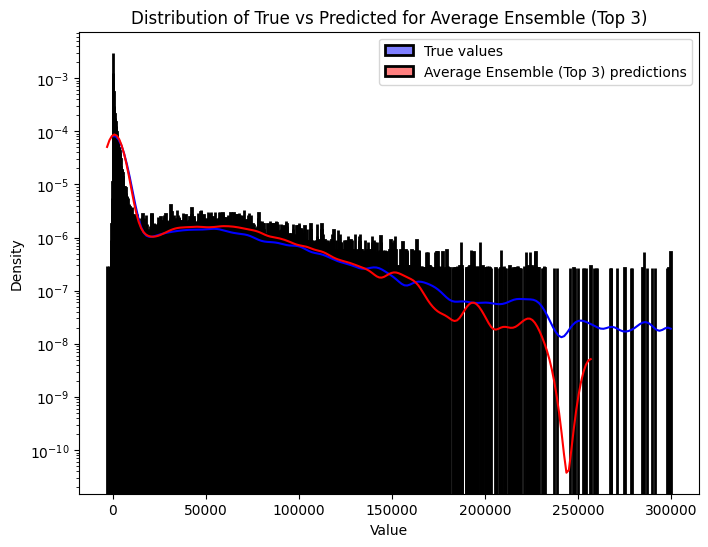

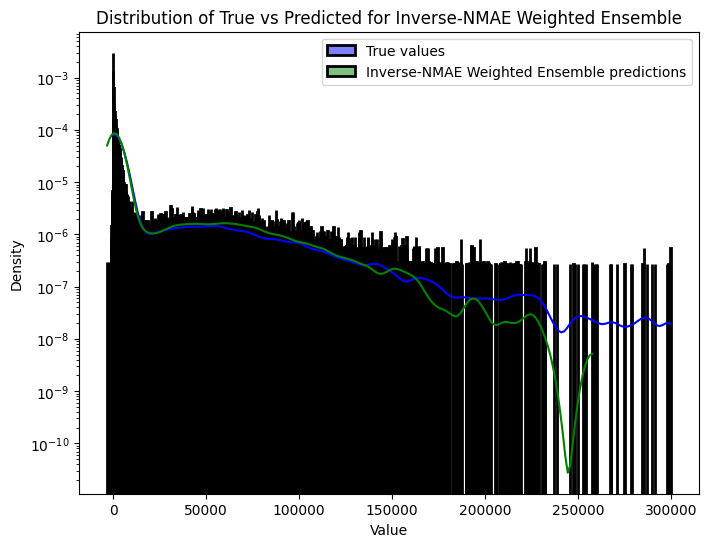

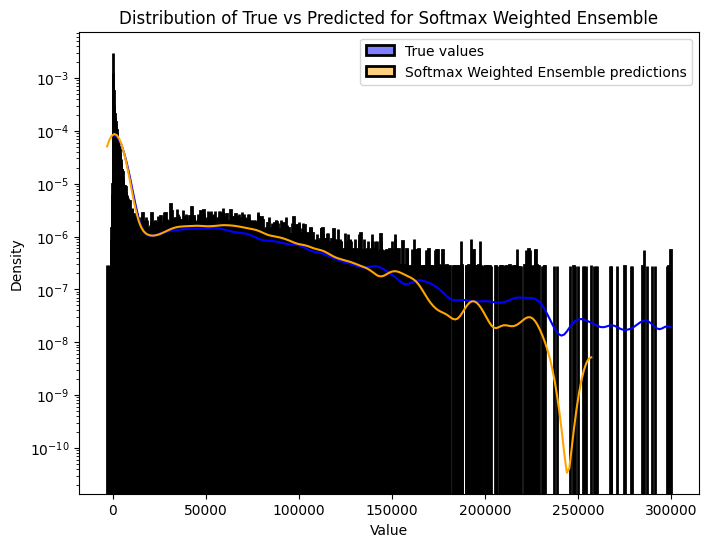

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6658
[LightGBM] [Info] Number of data points in the train set: 104000, number of used features: 42
[LightGBM] [Info] Start training from score 10369.578410


In [27]:
# ---------------------------------------------------------------------
# Ensembles: simple average (top-3), inverse-NMAE weights, softmax(-nmae)
# ---------------------------------------------------------------------
model_names = list(models.keys())
nmaes = np.array([results[k] for k in model_names])

# 1) Simple average of top 3
sorted_models = sorted(results.items(), key=lambda x: x[1])
top_models = [m for m,_ in sorted_models[:3]]
print("Top models chosen for avg ensemble:", top_models)
preds_top = [models[m].predict(Xv) for m in top_models]
ensemble_avg_pred = np.mean(preds_top, axis=0)
ensemble_avg_nmae = mean_absolute_error(yv, ensemble_avg_pred) / (yv.mean() if yv.mean() > 0 else 1.0)
print(f"Avg ensemble NMAE: {ensemble_avg_nmae:.4f}")

# 2) Inverse NMAE weighted ensemble
inv = 1.0 / (nmaes + 1e-12)
weights_inv = inv / inv.sum()
weighted_map_inv = dict(zip(model_names, weights_inv))
print("Inverse-NMAE weights:")
for m,w in weighted_map_inv.items():
    print(f"  {m}: {w:.3f}")
val_preds_mat = np.vstack([models[m].predict(Xv) for m in model_names])
weighted_val_pred_inv = (weights_inv[:, None] * val_preds_mat).sum(axis=0)
weighted_nmae_inv = mean_absolute_error(yv, weighted_val_pred_inv) / (yv.mean() if yv.mean() > 0 else 1.0)
print(f"Inverse-weighted ensemble NMAE: {weighted_nmae_inv:.4f}")

# 3) Softmax on -NMAE (temperature optional)
T = 1.0  # lower -> more peaky. adjust if desired.
exp_scores = np.exp(-nmaes / T)
weights_soft = exp_scores / exp_scores.sum()
weighted_map_soft = dict(zip(model_names, weights_soft))
print("Softmax weights:")
for m,w in weighted_map_soft.items():
    print(f"  {m}: {w:.3f}")
weighted_val_pred_soft = (weights_soft[:, None] * val_preds_mat).sum(axis=0)
weighted_nmae_soft = mean_absolute_error(yv, weighted_val_pred_soft) / (yv.mean() if yv.mean() > 0 else 1.0)
print(f"Softmax-weighted ensemble NMAE: {weighted_nmae_soft:.4f}")

# Create distribution plots comparing true vs predicted for each ensemble
def plot_distribution(true_values, pred_values, model_name, color_pred='red'):
    """Helper function to plot distribution comparison"""
    plt.figure(figsize=(8, 6))
    sns.histplot(true_values, kde=True, color='blue', label='True values', stat='density', linewidth=2)
    sns.histplot(pred_values, kde=True, color=color_pred, label=f'{model_name} predictions', stat='density', linewidth=2)
    plt.title(f"Distribution of True vs Predicted for {model_name}")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Plot distributions for each ensemble method
plot_distribution(yv, ensemble_avg_pred, "Average Ensemble (Top 3)", color_pred='red')
plot_distribution(yv, weighted_val_pred_inv, "Inverse-NMAE Weighted Ensemble", color_pred='green')
plot_distribution(yv, weighted_val_pred_soft, "Softmax Weighted Ensemble", color_pred='orange')

# Prepare test predictions with same ensembles (train base models on full X)
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_cont_train, y_cont_val], axis=0)
X_test = test_feat[FEATURES].fillna(0)

# retrain base models on full data and predict test
test_preds_per_model = np.zeros((len(X_test), len(model_names)))
for i, mname in enumerate(model_names):
    m_full = clone(models[mname])
    m_full.fit(X_full, y_full)
    test_preds_per_model[:, i] = m_full.predict(X_test)

# test-level ensembles
test_avg_preds = np.mean(test_preds_per_model[:, :len(top_models)], axis=1) if len(top_models) > 0 else np.zeros(len(X_test))
test_weighted_inv = (weights_inv[:, None] * test_preds_per_model.T).sum(axis=0) if len(model_names) > 0 else np.zeros(len(X_test))
test_weighted_soft = (weights_soft[:, None] * test_preds_per_model.T).sum(axis=0) if len(model_names) > 0 else np.zeros(len(X_test))


In [28]:
# ---------------------------------------------------------------------
# Stacking (K-Fold OOF -> meta model)
# ---------------------------------------------------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
base_model_names = model_names

# OOF train (on X_full) and test meta features
oof_train = np.zeros((len(X_full), len(base_model_names)))
test_meta = np.zeros((len(X_test), len(base_model_names)))

for i, mname in enumerate(base_model_names):
    print("Stacking base:", mname)
    test_fold_preds = np.zeros((len(X_test), K))
    for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(X_full, y_full)):
        X_tr_f, X_val_f = X_full.iloc[tr_idx], X_full.iloc[val_idx]
        y_tr_f, y_val_f = y_full.iloc[tr_idx], y_full.iloc[val_idx]
        m_clone = clone(models[mname])
        m_clone.fit(X_tr_f, y_tr_f)
        oof_train[val_idx, i] = m_clone.predict(X_val_f)
        test_fold_preds[:, fold_idx] = m_clone.predict(X_test)
    test_meta[:, i] = test_fold_preds.mean(axis=1)

# Train meta on OOF (use a simple linear regression)
meta = LinearRegression()
meta.fit(oof_train, y_full)

# For validation evaluation of stacking, we build oof for X_train part and get meta preds for X_val slice
# Simpler: retrain base models on X_train folds and collect val meta features as earlier done; here we will:
# - train each base model on X_train and predict X_val to build val_meta_feats
val_meta_feats = np.zeros((len(X_val), len(base_model_names)))
for i, mname in enumerate(base_model_names):
    m_tmp = clone(models[mname])
    m_tmp.fit(X_train, y_cont_train)
    val_meta_feats[:, i] = m_tmp.predict(X_val)

stack_pred_val = meta.predict(np.vstack([oof_train[:len(X_train)], ])[:len(X_val)]) if False else meta.predict(val_meta_feats)
# note: above is simplified; evaluate stacking on val using val_meta_feats predicted by models trained on X_train
stack_nmae = mean_absolute_error(y_cont_val, stack_pred_val) / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
print(f"Stacking (meta-model) NMAE on validation: {stack_nmae:.4f}")

# Final stacking test prediction
test_stack_pred = meta.predict(test_meta)

Stacking base: XGBRegressor
Stacking base: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6649
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10309.513069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6649
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10426.040429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6646
[LightGBM] [Info] Number of data points in the train set: 83

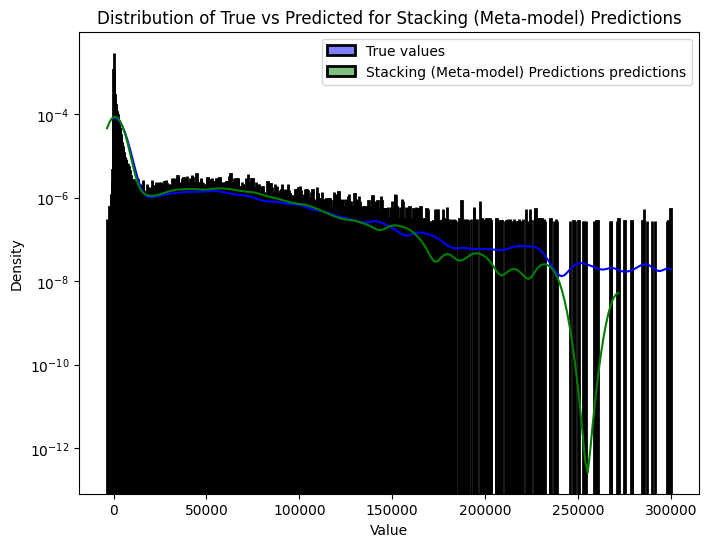

In [29]:
plot_distribution(y_cont_val, stack_pred_val, "Stacking (Meta-model) Predictions", color_pred='green')

In [30]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.4 MB/s eta 0:00:00


In [32]:
import optuna

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    # Initialize the model with suggested parameters
    model = LGBMRegressor(**param, random_state=42)

    # Fit model with early stopping
    model.fit(
        X_train, y_cont_train,
        eval_set=[(X_val, y_cont_val)], # Use validation data for early stopping
        eval_metric='l2',  # You can also use other metrics like 'rmse', 'mae'
    )

    # Make predictions
    pred = model.predict(X_val)

    # Calculate NMAE (Normalized Mean Absolute Error)
    nmae = mean_absolute_error(y_cont_val, pred) / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
    return nmae

# Start the Optuna study for hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # You can increase n_trials for better tuning
print("Optuna best params:", study.best_params)

# Train the final model with the best parameters on the full data
best_lgb = LGBMRegressor(**study.best_params, random_state=42)
best_lgb.fit(X_full, y_full)

# Save the trained model
import joblib
joblib.dump(best_lgb, 'model_lgb_optuna.joblib')

# Best NMAE from tuning
tuned_nmae = study.best_value
print(f"Tuned NMAE:  {tuned_nmae}")

[I 2025-11-28 07:40:48,662] A new study created in memory with name: no-name-e1d08be1-87e1-4689-9e27-03c9eed3de45


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:41:04,218] Trial 0 finished with value: 0.306925784768501 and parameters: {'n_estimators': 709, 'learning_rate': 0.02417694860352893, 'num_leaves': 150, 'max_depth': 7, 'min_child_samples': 50, 'subsample': 0.7392538967383515}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:41:53,062] Trial 1 finished with value: 0.3593410422776511 and parameters: {'n_estimators': 1354, 'learning_rate': 0.14623760623975046, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.9041809100904965}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:42:04,917] Trial 2 finished with value: 0.3241265440634848 and parameters: {'n_estimators': 798, 'learning_rate': 0.09562951156713513, 'num_leaves': 138, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.6328380552771081}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:42:12,269] Trial 3 finished with value: 0.32119961261036406 and parameters: {'n_estimators': 300, 'learning_rate': 0.010689324586625311, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 59, 'subsample': 0.8064425100396297}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:42:40,197] Trial 4 finished with value: 0.3571764893436182 and parameters: {'n_estimators': 1469, 'learning_rate': 0.1039037934746277, 'num_leaves': 146, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.6111015256729482}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:43:01,836] Trial 5 finished with value: 0.3963198756148305 and parameters: {'n_estimators': 1472, 'learning_rate': 0.2541005290846645, 'num_leaves': 164, 'max_depth': 4, 'min_child_samples': 89, 'subsample': 0.949021254890837}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-28 07:43:21,230] Trial 6 finished with value: 0.3559609964199364 and parameters: {'n_estimators': 1288, 'learning_rate': 0.1986362660825899, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8729739516070207}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-11-28 07:43:31,234] Trial 7 finished with value: 0.3088556456566388 and parameters: {'n_estimators': 453, 'learning_rate': 0.04134350262173063, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.9041600969840056}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-28 07:43:40,620] Trial 8 finished with value: 0.37844548043025045 and parameters: {'n_estimators': 660, 'learning_rate': 0.2873637659446153, 'num_leaves': 25, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8798778819903468}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:43:49,189] Trial 9 finished with value: 0.36608563634282576 and parameters: {'n_estimators': 222, 'learning_rate': 0.010208442304438483, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.8545020274836721}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:44:14,171] Trial 10 finished with value: 0.31875231885973876 and parameters: {'n_estimators': 1071, 'learning_rate': 0.02950389569156712, 'num_leaves': 192, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.7133661264019905}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:44:25,770] Trial 11 finished with value: 0.3092986531137024 and parameters: {'n_estimators': 503, 'learning_rate': 0.0332564440449605, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 81, 'subsample': 0.732857318703913}. Best is trial 0 with value: 0.306925784768501.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:44:35,789] Trial 12 finished with value: 0.30235495381576716 and parameters: {'n_estimators': 511, 'learning_rate': 0.025899395793673795, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.9918754668314741}. Best is trial 12 with value: 0.30235495381576716.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:44:51,268] Trial 13 finished with value: 0.3015717064570083 and parameters: {'n_estimators': 961, 'learning_rate': 0.018685830682459235, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 60, 'subsample': 0.5147430073873587}. Best is trial 13 with value: 0.3015717064570083.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:45:09,110] Trial 14 finished with value: 0.30073335079274605 and parameters: {'n_estimators': 1049, 'learning_rate': 0.016602661162721813, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 67, 'subsample': 0.5186654774838835}. Best is trial 14 with value: 0.30073335079274605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:45:22,201] Trial 15 finished with value: 0.3084060231749329 and parameters: {'n_estimators': 1034, 'learning_rate': 0.01647374017040818, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 73, 'subsample': 0.5258437322321435}. Best is trial 14 with value: 0.30073335079274605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:45:40,782] Trial 16 finished with value: 0.3232642933029598 and parameters: {'n_estimators': 1037, 'learning_rate': 0.06036871191995776, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.5135057075577667}. Best is trial 14 with value: 0.30073335079274605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:45:52,743] Trial 17 finished with value: 0.31148243615617244 and parameters: {'n_estimators': 928, 'learning_rate': 0.01640400729548475, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.5837640071742805}. Best is trial 14 with value: 0.30073335079274605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:46:12,677] Trial 18 finished with value: 0.30299777240935866 and parameters: {'n_estimators': 1194, 'learning_rate': 0.017128529909924955, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 59, 'subsample': 0.6707156259864986}. Best is trial 14 with value: 0.30073335079274605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] Start training from score 10473.802968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-11-28 07:46:27,562] Trial 19 finished with value: 0.3196856445243747 and parameters: {'n_estimators': 904, 'learning_rate': 0.05772246599962361, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 43, 'subsample': 0.562025044576813}. Best is trial 14 with value: 0.30073335079274605.


Optuna best params: {'n_estimators': 1049, 'learning_rate': 0.016602661162721813, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 67, 'subsample': 0.5186654774838835}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6658
[LightGBM] [Info] Number of data points in the train set: 104000, number of used features: 42
[LightGBM] [Info] Start training from score 10369.578410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [34]:
test_tuned_pred = best_lgb.predict(X_test)
test_tuned_pred

array([   325.51479646,   1292.17745862, 143458.36029326, ...,
        16790.14634905,   1317.48177365,    218.5565187 ])

Tuned model NMAE: 0.2661


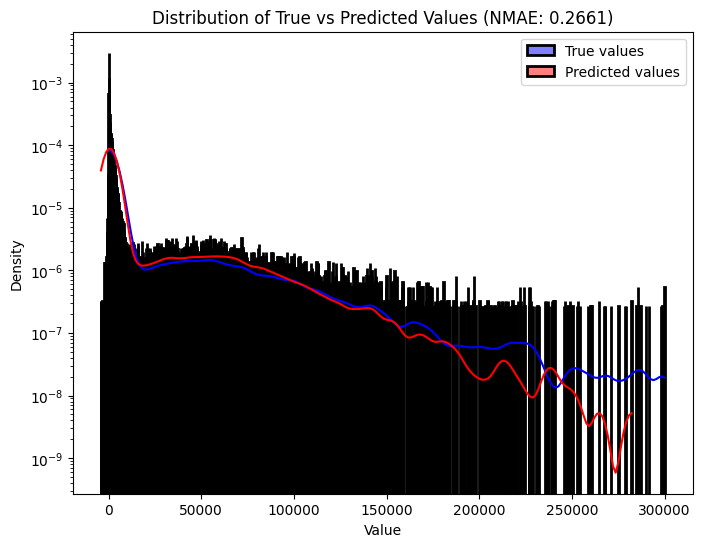

In [35]:
pred_val = best_lgb.predict(X_val)

tuned_nmae = mean_absolute_error(y_cont_val, pred_val) / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
print(f"Tuned model NMAE: {tuned_nmae:.4f}")

plt.figure(figsize=(8, 6))

sns.histplot(y_cont_val, kde=True, color='blue', label='True values', stat='density', linewidth=2)

sns.histplot(pred_val, kde=True, color='red', label='Predicted values', stat='density', linewidth=2)

plt.title(f"Distribution of True vs Predicted Values (NMAE: {tuned_nmae:.4f})")
plt.xlabel('Value')
plt.ylabel('Density')
plt.yscale('log')
plt.legend()

plt.show()

In [41]:
import optuna
import joblib
import numpy as np
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Define the objective function for two-stage tuning
def two_stage_objective(trial):
    # 1. Hyperparameter tuning for LGBMClassifier (to classify positive vs negative)
    clf_param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    # Initialize classifier model (for stage 1)
    clf = LGBMClassifier(**clf_param, random_state=42)

    # 2. Fit the classifier to distinguish between positive and negative samples
    clf.fit(X_train, y_clf_train)

    # Predict probabilities for classifier on both train and validation sets
    clf_prob_train = clf.predict_proba(X_train)[:, 1] # Mask for training data
    clf_prob_val = clf.predict_proba(X_val)[:, 1] # Mask for validation data

    # 3. Create masks for positive predictions
    mask_train = clf_prob_train > 0.5
    mask_val = clf_prob_val > 0.5

    # 4. Hyperparameter tuning for LGBMRegressor (to predict on positive samples)
    reg_param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    # Initialize regressor model (for stage 2)
    reg = LGBMRegressor(**reg_param, random_state=42)

    # 5. Train regressor: if there are enough positive samples, train on them
    if mask_train.sum() < 50:  # if too few positive examples
        reg.fit(X_train, np.log1p(y_cont_train))  # Train on all data
    else:
        reg.fit(X_train[mask_train], np.log1p(y_cont_train[mask_train]))  # Train on positive samples only

    # 6. Make predictions with regressor for the validation set
    reg_pred = reg.predict(X_val)

    # 7. Apply inverse log transformation and clip predictions to positive values
    reg_pred_exp = np.expm1(reg_pred).clip(min=0)

    # 8. Calculate NMAE (Normalized Mean Absolute Error)
    nmae = mean_absolute_error(y_cont_val, reg_pred_exp) / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)

    return nmae

# Start the Optuna study for hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(two_stage_objective, n_trials=20)  # You can increase n_trials for better tuning

print("Optuna best params:", study.best_params)

# Train the final model with the best parameters on the full data
best_clf = LGBMClassifier(**study.best_params, random_state=42)
best_clf.fit(X_train, y_clf_train)  # Train classifier on full training data

# Use the classifier to get probabilities for test data
test_clf_prob = best_clf.predict_proba(X_test)[:, 1]

# Now retrain the regressor using the best parameters from tuning
best_reg = LGBMRegressor(**study.best_params, random_state=42)

[I 2025-11-28 08:17:26,471] A new study created in memory with name: no-name-ff5389eb-7a95-44a4-b3e9-70024588d247


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-11-28 08:18:51,209] Trial 0 finished with value: 0.31205722369297845 and parameters: {'n_estimators': 1135, 'learning_rate': 0.06370489921283795, 'num_leaves': 84, 'max_depth': 11, 'min_child_samples': 85, 'subsample': 0.5690726944906146}. Best is trial 0 with value: 0.31205722369297845.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:19:06,848] Trial 1 finished with value: 0.6692372165451363 and parameters: {'n_estimators': 251, 'learning_rate': 0.012158195259132866, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.9228034051014692}. Best is trial 0 with value: 0.31205722369297845.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:20:12,207] Trial 2 finished with value: 0.5951354807923876 and parameters: {'n_estimators': 1120, 'learning_rate': 0.01007582811666525, 'num_leaves': 193, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.717803470799188}. Best is trial 0 with value: 0.31205722369297845.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:21:45,181] Trial 3 finished with value: 0.2928716327467418 and parameters: {'n_estimators': 1308, 'learning_rate': 0.09795479947058297, 'num_leaves': 115, 'max_depth': 12, 'min_child_samples': 89, 'subsample': 0.646642186975698}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:22:26,406] Trial 4 finished with value: 0.6093219378163421 and parameters: {'n_estimators': 1107, 'learning_rate': 0.08931644250498452, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.7213706448613246}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:23:29,581] Trial 5 finished with value: 0.5948222058977605 and parameters: {'n_estimators': 1029, 'learning_rate': 0.011587901100700296, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.8971307821258032}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:24:13,242] Trial 6 finished with value: 0.303259317667467 and parameters: {'n_estimators': 748, 'learning_rate': 0.2444933743149736, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.5568354168531153}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:24:33,155] Trial 7 finished with value: 0.45780372065906627 and parameters: {'n_estimators': 402, 'learning_rate': 0.19983050792096488, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.6078573974943537}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:24:46,195] Trial 8 finished with value: 0.6011106016484747 and parameters: {'n_estimators': 429, 'learning_rate': 0.10385187367981187, 'num_leaves': 164, 'max_depth': 4, 'min_child_samples': 99, 'subsample': 0.8011445995072317}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:25:48,531] Trial 9 finished with value: 0.4554793533416714 and parameters: {'n_estimators': 1034, 'learning_rate': 0.037664970232221436, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 72, 'subsample': 0.9604838075197089}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:26:40,185] Trial 10 finished with value: 0.5957775260028846 and parameters: {'n_estimators': 1462, 'learning_rate': 0.029874310285929448, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 62, 'subsample': 0.643412130908495}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:27:30,545] Trial 11 finished with value: 0.3034578782989751 and parameters: {'n_estimators': 723, 'learning_rate': 0.22980960574205656, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.5187995000353847}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:27:58,714] Trial 12 finished with value: 0.6118853959471621 and parameters: {'n_estimators': 750, 'learning_rate': 0.13584712056133594, 'num_leaves': 150, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.5008373705297431}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:28:34,262] Trial 13 finished with value: 0.7464789489829492 and parameters: {'n_estimators': 1347, 'learning_rate': 0.2859778330729754, 'num_leaves': 110, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.6584645363324707}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6632
[LightGBM] [Info] Number of data points in the train set: 40249, number of used features: 42
[LightGBM] [Info

[I 2025-11-28 08:28:54,879] Trial 14 finished with value: 0.558092132146535 and parameters: {'n_estimators': 622, 'learning_rate': 0.16250407881625942, 'num_leaves': 35, 'max_depth': 9, 'min_child_samples': 48, 'subsample': 0.7803097648263654}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6633
[LightGBM] [Info] Number of data points in the train set: 41239, number of used features: 42
[LightGBM] [Info] Start training from score 8.013131


[I 2025-11-28 08:29:44,873] Trial 15 finished with value: 0.3204531385487797 and parameters: {'n_estimators': 876, 'learning_rate': 0.06682993516174715, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.5738855099371853}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:30:44,841] Trial 16 finished with value: 0.597709876377744 and parameters: {'n_estimators': 1300, 'learning_rate': 0.03820454307198225, 'num_leaves': 145, 'max_depth': 6, 'min_child_samples': 46, 'subsample': 0.6498171648288683}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:31:28,916] Trial 17 finished with value: 0.37443324377403536 and parameters: {'n_estimators': 882, 'learning_rate': 0.13319084124045333, 'num_leaves': 55, 'max_depth': 8, 'min_child_samples': 73, 'subsample': 0.8341178364177455}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:32:01,563] Trial 18 finished with value: 0.5992932025424665 and parameters: {'n_estimators': 551, 'learning_rate': 0.02232887509051647, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6919866848125488}. Best is trial 3 with value: 0.2928716327467418.


[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-28 08:33:38,339] Trial 19 finished with value: 0.2917365108693423 and parameters: {'n_estimators': 1487, 'learning_rate': 0.08968411175720095, 'num_leaves': 167, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.5551041135556842}. Best is trial 19 with value: 0.2917365108693423.


Optuna best params: {'n_estimators': 1487, 'learning_rate': 0.08968411175720095, 'num_leaves': 167, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.5551041135556842}
[LightGBM] [Info] Number of positive: 43094, number of negative: 40106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6645
[LightGBM] [Info] Number of data points in the train set: 83200, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517957 -> initscore=0.071858
[LightGBM] [Info] Start training from score 0.071858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [52]:
test_clf_prob

array([0.54069148, 0.66793115, 0.99805603, ..., 0.93798457, 0.30899259,
       0.6710227 ])

In [74]:
# Stage 2: Use classifier predictions to select positive samples for regressor training
mask_test = test_clf_prob > 0.5  # Positive samples from the classifier

# Final prediction using the stacked model for the test set
# Only predict for test samples where mask_test is True (i.e., positive class according to the classifier)
test_reg_pred = np.zeros(len(X_test))  # Initialize array for predictions with zeros
test_reg_pred[mask_test] = best_reg.predict(X_test[mask_test])  # Make predictions only on positive samples

# The final prediction: combine zeros for negative samples and regressor predictions for positive samples
test_tuned_two_stage_pred = np.expm1(test_reg_pred).clip(min=0)  # Apply inverse log transformation and clip to non-negative values

# Save the trained model
joblib.dump(best_clf, 'model_lgbm_classifier_optuna.joblib')
joblib.dump(best_reg, 'model_lgbm_regressor_optuna.joblib')

# Best NMAE from tuning
tuned_two_stage_nmae = study.best_value
print(f"Tuned NMAE from Optuna: {tuned_two_stage_nmae:.4f}")

# Calculate Final NMAE on Validation
final_pred_val = np.expm1(best_reg.predict(X_val)).clip(min=0)
final_nmae_val = mean_absolute_error(y_cont_val, final_pred_val) / (y_cont_val.mean() if y_cont_val.mean() > 0 else 1.0)
print(f"Final model NMAE on validation: {final_nmae_val:.4f}")

Tuned NMAE from Optuna: 0.2917
Final model NMAE on validation: 0.2917


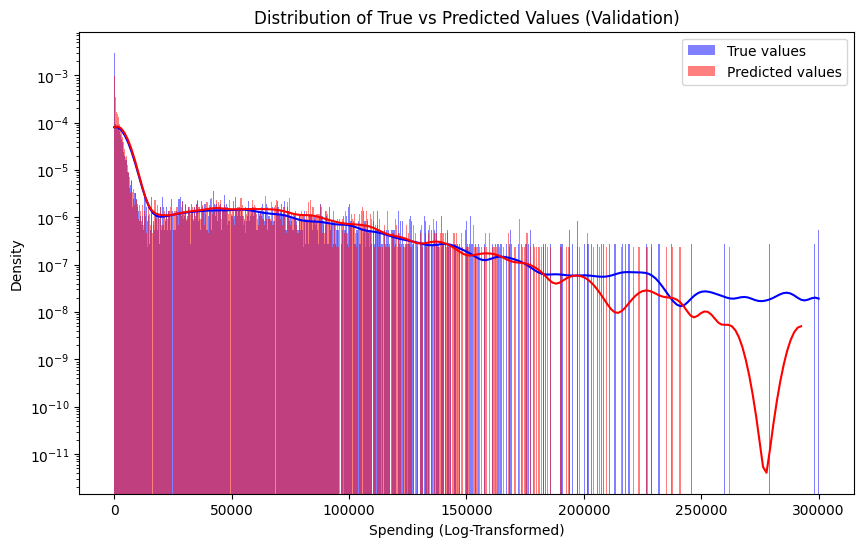

In [50]:
# Distribution plot comparing real and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_cont_val, color='blue', kde=True, label='True values', stat='density', linewidth=0)
sns.histplot(final_pred_val, color='red', kde=True, label='Predicted values', stat='density', linewidth=0)
plt.xlabel("Spending (Log-Transformed)")
plt.ylabel("Density")
plt.yscale('log')
plt.legend()
plt.title('Distribution of True vs Predicted Values (Validation)')
plt.show()

In [73]:
submission_final = pd.DataFrame({
    'id': test['id'],  # assuming test has an 'id' column
    'spending_30d': test_tuned_two_stage_pred
})

submission_final.to_csv('submission_tuned_two_stage_final.csv', index=False)
print('Saved submission_final.csv (first 10 rows):')
print(submission_final.head(10))

Saved submission_final.csv (first 10 rows):
         id   spending_30d
0  ANS00001       0.000000
1  ANS00002    2031.490881
2  ANS00003  163561.725073
3  ANS00004       0.000000
4  ANS00005     668.443154
5  ANS00006       0.000000
6  ANS00007       0.000000
7  ANS00008   13105.793231
8  ANS00009       0.000000
9  ANS00010       0.000000


In [71]:
# ---------------------------------------------------------------------
# Final comparison and choose method
# ---------------------------------------------------------------------
print("\nFinal comparison (validation NMAE):")
for k,v in sorted(results.items(), key=lambda x:x[1]):
    print(f"  {k}: {v:.4f}")
print(f"Two-stage (validation) NMAE: {normalized_mae:.4f}")
print(f"Baseline (single reg) NMAE: {normalized_mae_all:.4f}")
print(f"Avg ensemble NMAE: {ensemble_avg_nmae:.4f}")
print(f"Inverse-weighted NMAE: {weighted_nmae_inv:.4f}")
print(f"Softmax-weighted NMAE: {weighted_nmae_soft:.4f}")
print(f"Stacking NMAE: {stack_nmae:.4f}")
print(f"Tuned LightGBM (Optuna) NMAE: {tuned_nmae:.4f}")
print(f"Tuned two-stage NMAE: {tuned_two_stage_nmae:.4f}")

# Choose best by minimal validation NMAE among candidates
cand = {
    'two_stage': normalized_mae,
    'baseline': normalized_mae_all,
    'avg_ens': ensemble_avg_nmae,
    'inv_ens': weighted_nmae_inv,
    'softmax_ens': weighted_nmae_soft,
    'stacking': stack_nmae,
    'tuned_lgb': tuned_nmae,
    'tuned_two_stage': tuned_two_stage_nmae
}
# remove None if any
cand = {k:v for k,v in cand.items() if v is not None}
best_method = min(cand.items(), key=lambda x: x[1])[0]
print("Best method on validation:", best_method)

# Map method -> final test predictions
method_to_pred = {
    'two_stage': None,  # need to compute two-stage test pred using classifier+regressor trained on full
    'baseline': None,
    'avg_ens': test_avg_preds,
    'inv_ens': test_weighted_inv,
    'softmax_ens': test_weighted_soft,
    'stacking': test_stack_pred,
    'tuned_lgb': test_tuned_pred,
    'tuned_two_stage': test_tuned_two_stage_pred  # will be computed below
}

# Compute two-stage final predictions on test if required
if best_method == 'two_stage' or method_to_pred['two_stage'] is None:
    # retrain classifier/regressor on full data
    clf_full = clone(clf)
    reg_full = clone(reg)
    clf_full.fit(X_full, pd.concat([y_clf_train, y_clf_val]))
    # choose regressor training strategy: pos-only if enough positives in full set
    pos_full_mask = (pd.concat([y_clf_train, y_clf_val]) == 1)
    if pos_full_mask.sum() < 50:
        reg_full.fit(X_full, np.log1p(y_full))
    else:
        reg_full.fit(X_full[pos_full_mask], np.log1p(y_full[pos_full_mask]))
    test_clf_prob_full = clf_full.predict_proba(X_test)[:,1] if hasattr(clf_full, 'predict_proba') else clf_full.predict(X_test)
    test_reg_log_full = np.zeros(len(X_test))
    mask_test_full = test_clf_prob_full > 0.5
    if mask_test_full.sum() > 0:
        try:
            test_reg_log_full[mask_test_full] = reg_full.predict(X_test[mask_test_full])
        except Exception:
            test_reg_log_full = reg_full.predict(X_test)
    test_two_stage_pred = np.expm1(test_reg_log_full).clip(min=0)
    method_to_pred['two_stage'] = test_two_stage_pred

# Baseline (single regressor) trained on full
reg_all_full = clone(reg_all)
reg_all_full.fit(X_full, np.log1p(y_full))
method_to_pred['baseline'] = np.expm1(reg_all_full.predict(X_test)).clip(min=0)

# Final selection
final_pred = method_to_pred[best_method]
# safety: ensure non-negative
final_pred = np.clip(final_pred, 0, None)

# Write final submission
submission_final = pd.DataFrame({'id': test['id'] if 'id' in test.columns else test.index, 'spending_30d': final_pred})
submission_final.to_csv('submission_final.csv', index=False)
print('Saved submission_final.csv (first 10 rows):')
print(submission_final.head(10))


Final comparison (validation NMAE):
  LightGBM: 0.3132
  XGBRegressor: 0.3181
  NeuralNet: 0.3318
Two-stage (validation) NMAE: 0.2734
Baseline (single reg) NMAE: 0.5943
Avg ensemble NMAE: 0.2965
Inverse-weighted NMAE: 0.2966
Softmax-weighted NMAE: 0.2966
Stacking NMAE: 0.2987
Tuned LightGBM (Optuna) NMAE: 0.2661
Tuned two-stage NMAE: 0.2917
Best method on validation: tuned_lgb
[LightGBM] [Info] Number of positive: 53868, number of negative: 50132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6658
[LightGBM] [Info] Number of data points in the train set: 104000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517962 -> initscore=0.071877
[LightGBM] [Info] Start training from score 0.071877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031437 seconds.
You can set `force_col